In [1]:
import nfl_data_py as nfl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np

plt.style.use('ggplot')

pd.set_option('display.max_columns', 10)

In [2]:
seasons = [year for year in range(1999, 2022)]

In [3]:
data = nfl.import_pbp_data(seasons)

1999 done.
2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
Downcasting floats.


We will use exponentially weighted EPA for our features of the machine learning model. We will be doing a rolling average with a dynamic window. The way this works is that we will use a window size of 10 for games that are before week 10 of the season (so we will include games from the previous season). Then, after week 10, our window size will just be the entire current season. 

We will do 8 exponentially weighted rolling EPAs for our features. 
1. Home team passing offense EPA/play
2. Home team passing defense EPA/play
3. Home team rushing offense EPA/play
4. Home team rushing defense EPA/play
5-8: Same except away team

In [6]:
data.head()

,play_id,game_id,old_game_id,home_team,away_team,...,time_to_throw,was_pressure,route,defense_man_zone_type,defense_coverage_type
0,35.0,1999_01_ARI_PHI,1999091200,PHI,ARI,...,NaN,NaN,NaN,NaN,NaN
1,60.0,1999_01_ARI_PHI,1999091200,PHI,ARI,...,NaN,NaN,NaN,NaN,NaN
2,82.0,1999_01_ARI_PHI,1999091200,PHI,ARI,...,NaN,NaN,NaN,NaN,NaN
3,103.0,1999_01_ARI_PHI,1999091200,PHI,ARI,...,NaN,NaN,NaN,NaN,NaN
4,126.0,1999_01_ARI_PHI,1999091200,PHI,ARI,...,NaN,NaN,NaN,NaN,NaN


In [7]:

def dynamic_window_ewma(x):
    """
    Calculate rolling exponentially weighted EPA with a dynamic window size
    """
    values = np.zeros(len(x))
    for i, (_, row) in enumerate(x.iterrows()):
        epa = x.epa_shifted[:i+1]
        if row.week > 10:
            values[i] = epa.ewm(min_periods=1, span=row.week).mean().values[-1]
        else:
            values[i] = epa.ewm(min_periods=1, span=10).mean().values[-1]
            
    return pd.Series(values, index=x.index)

In [2]:
# seperate EPA in to rushing offense, rushing defense, passing offense, passing defense for each team
rushing_offense_epa = data.loc[data['rush_attempt'] == 1, :].groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()

rushing_defense_epa = data.loc[data['rush_attempt'] == 1, :].groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

passing_offense_epa = data.loc[data['pass_attempt'] == 1, :].groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()

passing_defense_epa = data.loc[data['pass_attempt'] == 1, :].groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

NameError: name 'data' is not defined

In [1]:
rushing_offense_epa

NameError: name 'rushing_offense_epa' is not defined

In [12]:
# lag EPA one period back
rushing_offense_epa['epa_shifted'] = rushing_offense_epa.groupby('posteam')['epa'].shift()
rushing_defense_epa['epa_shifted'] = rushing_defense_epa.groupby('defteam')['epa'].shift()
passing_offense_epa['epa_shifted'] = passing_offense_epa.groupby('posteam')['epa'].shift()
passing_defense_epa['epa_shifted'] = passing_defense_epa.groupby('defteam')['epa'].shift()

#You can see that week 1 1999 epa becomes week 2 1999 epa for epa_shifted. I think we do this to simulate the timing of when we actually gain knowledge during an NFL season. 
rushing_offense_epa

,posteam,season,week,epa,epa_shifted
0,ARI,1999,1,-0.279451,NaN
1,ARI,1999,2,-0.284510,-0.279451
2,ARI,1999,3,-0.050171,-0.284510
3,ARI,1999,4,-0.743253,-0.050171
4,ARI,1999,5,-0.340250,-0.743253
...,...,...,...,...,...
12263,WAS,2021,14,0.176988,-0.142624
12264,WAS,2021,15,-0.202773,0.176988
12265,WAS,2021,16,-0.047970,-0.202773
12266,WAS,2021,17,0.133991,-0.047970


In [13]:
# In each case, calculate EWMA with a static window and dynamic window and assign it as a column 
rushing_offense_epa['ewma'] = rushing_offense_epa.groupby('posteam')['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_offense_epa['ewma_dynamic_window'] = rushing_offense_epa.groupby('posteam').apply(dynamic_window_ewma).values

rushing_defense_epa['ewma'] = rushing_defense_epa.groupby('defteam')['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_defense_epa['ewma_dynamic_window'] = rushing_defense_epa.groupby('defteam').apply(dynamic_window_ewma).values

passing_offense_epa['ewma'] = passing_offense_epa.groupby('posteam')['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_offense_epa['ewma_dynamic_window'] = passing_offense_epa.groupby('posteam').apply(dynamic_window_ewma).values

passing_defense_epa['ewma'] = passing_defense_epa.groupby('defteam')['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_defense_epa['ewma_dynamic_window'] = passing_defense_epa.groupby('defteam').apply(dynamic_window_ewma).values


In [14]:
rushing_defense_epa.columns

Index(['defteam', 'season', 'week', 'epa', 'epa_shifted', 'ewma',
       'ewma_dynamic_window'],
      dtype='object')

In [15]:
#Merge all the data together
offense_epa = rushing_offense_epa.merge(passing_offense_epa, on=['posteam', 'season', 'week'], suffixes=('_rushing', '_passing')).rename(columns={'posteam': 'team'})

defense_epa = rushing_defense_epa.merge(passing_defense_epa, on=['defteam', 'season', 'week'], suffixes=('_rushing', '_passing')).rename(columns={'defteam': 'team'})

epa = offense_epa.merge(defense_epa, on=['team', 'season', 'week'], suffixes=('_offense', '_defense'))

In [16]:
offense_epa.head()

,team,season,week,epa_rushing,epa_shifted_rushing,...,ewma_dynamic_window_rushing,epa_passing,epa_shifted_passing,ewma_passing,ewma_dynamic_window_passing
0,ARI,1999,1,-0.279451,NaN,...,NaN,-0.038225,NaN,NaN,NaN
1,ARI,1999,2,-0.284510,-0.279451,...,-0.279451,-0.547385,-0.038225,-0.038225,-0.038225
2,ARI,1999,3,-0.050171,-0.284510,...,-0.282233,-0.402781,-0.547385,-0.318263,-0.318263
3,ARI,1999,4,-0.743253,-0.050171,...,-0.188946,-0.349102,-0.402781,-0.352239,-0.352239
4,ARI,1999,5,-0.340250,-0.743253,...,-0.371565,0.066618,-0.349102,-0.351205,-0.351205


In [19]:
#remove the first season of data
epa = epa.loc[epa['season'] != epa['season'].unique()[0], :]

epa = epa.reset_index(drop=True)

In [20]:
#Here is our dataframe with our features.  
epa.head()

,team,season,week,epa_rushing_offense,epa_shifted_rushing_offense,...,ewma_dynamic_window_rushing_defense,epa_passing_defense,epa_shifted_passing_defense,ewma_passing_defense,ewma_dynamic_window_passing_defense
0,ARI,2000,1,-0.345669,-0.068545,...,0.086016,-0.009200,0.269840,0.115978,0.115978
1,ARI,2000,2,-0.276743,-0.345669,...,0.101092,0.283460,-0.009200,0.092441,0.092441
2,ARI,2000,4,-0.334533,-0.276743,...,0.069872,0.500345,0.283460,0.128136,0.128136
3,ARI,2000,5,-0.016838,-0.334533,...,0.053437,0.058499,0.500345,0.197339,0.197339
4,ARI,2000,6,-0.038473,-0.016838,...,0.044399,-0.063633,0.058499,0.171631,0.171631


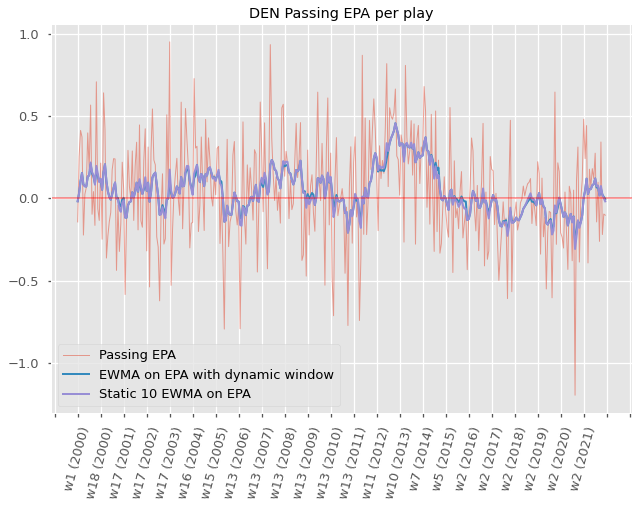

In [21]:
#Here is a look at how our non-moving average epa, EWMA with static window, and EWMA with dynamic window all stack up
tm = epa.loc[epa['team'] == 'DEN', :].assign(
    season_week = lambda x: 'w' + x.week.astype(str) + ' (' + x.season.astype(str) + ')'
).set_index('season_week')

fig, ax = plt.subplots()

loc = plticker.MultipleLocator(base=16) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.tick_params(axis='x', rotation=75) #rotate the x-axis labels a bit

ax.plot(tm['epa_shifted_passing_offense'], lw=1, alpha=0.5)
ax.plot(tm['ewma_dynamic_window_passing_offense'], lw=2)
ax.plot(tm['ewma_passing_offense'], lw=2);
plt.axhline(y=0, color='red', lw=1.5, alpha=0.5)

ax.legend(['Passing EPA', 'EWMA on EPA with dynamic window', 'Static 10 EWMA on EPA'])
ax.set_title('DEN Passing EPA per play')
plt.show();

In [24]:
#Now we want to merge in game result data to get our target value.
schedule = data[['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score','spread_line']].drop_duplicates().reset_index(drop=True).assign(home_team_win = lambda x: (x.home_score > x.away_score).astype(int))

def iscover(x):
    dif = x.home_score - x.away_score
    line = x.spread_line
    if dif <= line:
        return 1
    else:
        return 0

schedule['home_team_cover'] = schedule.apply(iscover,axis=1)

print(schedule.home_team_cover.mean())

df = schedule.merge(epa.rename(columns={'team': 'home_team'}), on=['home_team', 'season', 'week']).merge(epa.rename(columns={'team': 'away_team'}), on=['away_team', 'season', 'week'], suffixes=('_home', '_away'))

0.5255950440169547


In [25]:
df.columns

Index(['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score',
       'spread_line', 'home_team_win', 'home_team_cover',
       'epa_rushing_offense_home', 'epa_shifted_rushing_offense_home',
       'ewma_rushing_offense_home', 'ewma_dynamic_window_rushing_offense_home',
       'epa_passing_offense_home', 'epa_shifted_passing_offense_home',
       'ewma_passing_offense_home', 'ewma_dynamic_window_passing_offense_home',
       'epa_rushing_defense_home', 'epa_shifted_rushing_defense_home',
       'ewma_rushing_defense_home', 'ewma_dynamic_window_rushing_defense_home',
       'epa_passing_defense_home', 'epa_shifted_passing_defense_home',
       'ewma_passing_defense_home', 'ewma_dynamic_window_passing_defense_home',
       'epa_rushing_offense_away', 'epa_shifted_rushing_offense_away',
       'ewma_rushing_offense_away', 'ewma_dynamic_window_rushing_offense_away',
       'epa_passing_offense_away', 'epa_shifted_passing_offense_away',
       'ewma_passing_offense_away', '

In [26]:
target = 'home_team_cover'
features = [column for column in df.columns if 'ewma' in column and 'dynamic' in column]
for feature in features:
  print(feature)

ewma_dynamic_window_rushing_offense_home

ewma_dynamic_window_passing_offense_home

ewma_dynamic_window_rushing_defense_home

ewma_dynamic_window_passing_defense_home

ewma_dynamic_window_rushing_offense_away

ewma_dynamic_window_passing_offense_away

ewma_dynamic_window_rushing_defense_away

ewma_dynamic_window_passing_defense_away


In [32]:
#Drop nas, get our features and target values, instantiate logistic regression model, and train model
df = df.dropna()

X = df.loc[df['season'] != 2020, features].values
y = df.loc[df['season'] != 2020, target].values

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X,y)

LogisticRegression()

In [33]:
#
accuracy_scores = cross_val_score(clf, X, y, cv=10)
log_losses = cross_val_score(clf, X, y, cv=10, scoring='neg_log_loss')

print('Model Accuracy:', np.mean(accuracy_scores))
print('Neg log loss:', np.mean(log_losses))

Model Accuracy: 0.5321087980646804

Neg log loss: -0.692111345102893


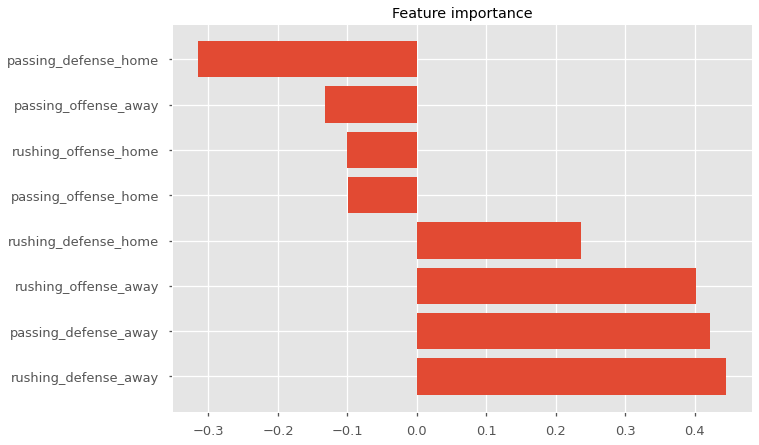

In [34]:
fig, ax = plt.subplots()

feature_names = ['_'.join(feature_name.split('_')[3:]) for feature_name in features]

coef_ = clf.coef_[0]

features_coef_sorted = sorted(zip(feature_names, coef_), key=lambda x:x[-1], reverse=True)

features_sorted = [feature for feature, _ in features_coef_sorted]
coef_sorted = [coef for _, coef in features_coef_sorted]

ax.set_title('Feature importance')

ax.barh(features_sorted, coef_sorted);
plt.show();

In [35]:
# We didn't train with 2020 data, so let's see how it predicts games
df_2020 = df.loc[(df['season'] == 2020)].assign(
    predicted_cover = lambda x: clf.predict(x[features]),
    home_team_cover_probability = lambda x: clf.predict_proba(x[features])[:, 1]
)#[['home_team', 'away_team', 'week', 'predicted_cover', 'home_team_cover_probability', 'home_team_cover']]

df_2020['actual_cover'] = df_2020.apply(lambda x: x.home_team if x.home_team_cover else x.away_team, axis=1)
df_2020['predicted_cover'] = df_2020.apply(lambda x: x.home_team if x.predicted_cover == 1 else x.away_team, axis=1)
df_2020['cover_probability'] = df_2020.apply(lambda x: x.home_team_cover_probability if x.predicted_cover == x.home_team else 1 - x.home_team_cover_probability, axis=1)
df_2020['correct_prediction'] = (df_2020['predicted_cover'] == df_2020['actual_cover']).astype(int)

df_2020 = df_2020.drop(columns=['home_team_cover_probability', 'home_team_cover'])

df_2020['bothTeams'] = df_2020.apply(lambda x: x.home_team+x.away_team, axis=1)
dalwk17 = df_2020[['DAL' in i for i in df_2020['bothTeams'].values]][features].iloc[15,:]
tbsb = df_2020[['TB' in i for i in df_2020['bothTeams'].values]][features].iloc[20,:]

c:\Users\austi\Anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names

  warnings.warn(

c:\Users\austi\Anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names

  warnings.warn(


In [36]:
df.loc[(df['season']==2020)].columns

Index(['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score',
       'spread_line', 'home_team_win', 'home_team_cover',
       'epa_rushing_offense_home', 'epa_shifted_rushing_offense_home',
       'ewma_rushing_offense_home', 'ewma_dynamic_window_rushing_offense_home',
       'epa_passing_offense_home', 'epa_shifted_passing_offense_home',
       'ewma_passing_offense_home', 'ewma_dynamic_window_passing_offense_home',
       'epa_rushing_defense_home', 'epa_shifted_rushing_defense_home',
       'ewma_rushing_defense_home', 'ewma_dynamic_window_rushing_defense_home',
       'epa_passing_defense_home', 'epa_shifted_passing_defense_home',
       'ewma_passing_defense_home', 'ewma_dynamic_window_passing_defense_home',
       'epa_rushing_offense_away', 'epa_shifted_rushing_offense_away',
       'ewma_rushing_offense_away', 'ewma_dynamic_window_rushing_offense_away',
       'epa_passing_offense_away', 'epa_shifted_passing_offense_away',
       'ewma_passing_offense_away', '

In [37]:
df_2020.correct_prediction.mean()

0.5018587360594795

In [38]:
dalwk17

ewma_dynamic_window_rushing_offense_home   -0.039383
ewma_dynamic_window_passing_offense_home   -0.083244
ewma_dynamic_window_rushing_defense_home   -0.060342
ewma_dynamic_window_passing_defense_home    0.122163
ewma_dynamic_window_rushing_offense_away   -0.062578
ewma_dynamic_window_passing_offense_away    0.034105
ewma_dynamic_window_rushing_defense_away   -0.041390
ewma_dynamic_window_passing_defense_away    0.019322
Name: 5565, dtype: float64

In [39]:
cowboysbucs = tbsb[:4].values.tolist()+dalwk17[4:].values.tolist()
gamedict = {feature:cowboysbucs[i] for i,feature in enumerate(features)}
cowboysbucs = np.array(cowboysbucs).reshape(1,-1)
print(clf.predict(cowboysbucs)[0])
clf.predict_proba(cowboysbucs)[0][0]


1


0.4656326746315297